In [23]:
import tensorflow as tf 
import keras 
import numpy as np 
import matplotlib.pyplot as plt
from keras import  Sequential
from keras.models import Model 
from keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Flatten, Add

In [24]:
# 이미지 값들 표준화
# 카테코리컬하게
from keras.utils import to_categorical 
num_classes = 10
class Data() :
    def __init__(self, category) :
        if category == 'mnist' :
            data_loader = keras.datasets.mnist.load_data
        elif category == 'cifar10' :
            data_loader = keras.datasets.cifar10.load_data
            
        (X_train, y_train), (X_test, y_test) = data_loader()

        self.raw_X_train = X_train
        self.raw_y_train = y_train
        
        X_train = X_train / 255.
        X_test = X_test / 255.

        if category == 'mnist' :
            X_train = X_train[:, :, :, tf.newaxis]
            X_test = X_test[:, :, :, tf.newaxis]

        Y_train = to_categorical(y_train, num_classes)
        Y_test = to_categorical(y_test, num_classes)
        
        self.X_train = X_train 
        self.Y_train = Y_train 
        self.X_test = X_test 
        self.Y_test = Y_test

In [25]:
class BasicBlock(Model) :
    def __init__(self, in_planes, planes, stride = 1):
        self.in_planes = in_planes
        self.planes = planes
        self.stride= stride 

        super(BasicBlock, self).__init__()

        self.conv1 = Conv2D(planes,
                        kernel_size= 3,
                        padding = 'same',
                        strides = stride ,
                        use_bias = False)
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(planes,
                        kernel_size= 3,
                        padding = 'same',
                        strides = 1 ,
                        use_bias = False)  
        self.bn2 = BatchNormalization()
        self.add = Add()
        
        if in_planes != planes or stride != 1 :
            self.shortcut = Sequential([
                Conv2D(self.planes, 
                       kernel_size= 1,
                       strides = self.stride,
                       use_bias = False),
                BatchNormalization()
            ])
        else :
            self.shortcut = lambda x : x

    def call(self, x) :
        residual = self.shortcut(x)
        out = self.bn1(self.conv1(x))
        out = self.bn2(self.conv2(out))
        out = self.add([out, residual])
        out = tf.nn.relu(out)
        return out 

In [26]:
class ResNet(Model) :
    def __init__(self, in_planes, num_classes = 10):
        super(ResNet, self).__init__()
        self.in_planes = 1 

        self.conv1 = Conv2D(16,
                            kernel_size= 3,
                            padding = 'same',
                            strides = 1,
                            use_bias = False)
        self.bn1 = BatchNormalization()
        self.layer1 = self._make_layer(16, 2, 1)
        self.layer2 = self._make_layer(32, 2, 2)
        self.layer3 = self._make_layer(64, 2, 2)
        self.linear = Dense(num_classes, activation='softmax')

    def _make_layer(self, planes, blocks, stride) :
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides :
            layers.append(BasicBlock(self.in_planes, planes, stride = stride))
            self.in_planes = planes 
        return Sequential(layers)
    
    def call(self, x) :
        out = self.bn1(self.conv1(x))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = AveragePooling2D((2,2))(out)
        out = Flatten()(out)
        out = self.linear(out)
        return out 

In [ ]:
file_path = f'./{self.category}/best_model'
keras.callbacks.ModelCheckpoint(filepath = file_path ,
                                save_best_only=True)

In [50]:
class Machine :
    def __init__(self, category) :
        self.data = Data(category)
        self.category = category
        if category == 'mnist' :
            in_planes = 1
        elif category == 'cifar10' :
            in_planes = 3
        model = ResNet(in_planes)
        model.compile('adam', 'categorical_crossentropy', ['accuracy'])
        self.model = model

    def callback(self, patience = 10) :
        es = keras.callbacks.EarlyStopping(patience)
        file_path = f'./{self.category}/best_model'
        bs = keras.callbacks.ModelCheckpoint(filepath = file_path ,
                                        save_best_only=True)
        return [es, bs]
    
    def image_check(self, X, y) :
        pltsize = 1 
        plt.figure(figsize=(pltsize * 10, pltsize))
        for i in range(10) :
            plt.subplot(1, 10, i + 1)
            if self.category == 'mnist' :
                plt.imshow(X[i], cmap='gray_r')
                plt.axis('off')
                plt.title(f'Class {str(y[i])}')
            elif self.category == 'cifar10' :
                plt.imshow(X[i])
                plt.axis('off')
                plt.title(f'Class {str(y[i][0])}')
        plt.show()

    def run(self, epochs = 20, batch_size = 128, callbacks = True) :
        data = self.data 
        model = self.model 
        print(f'\n----------{self.category}_Image_Check----------\n\n')
        self.image_check(data.raw_X_train, data.raw_y_train)
        print(f'\n----------{self.category}_Train_Start----------\n\n')
        callbacks = []
        if callbacks :
            callbacks = self.callback()
        else :
            callbacks = []
        model.fit(data.X_train, data.Y_train,
          epochs = epochs,
          batch_size = batch_size,
          validation_split=0.2,
          callbacks = callbacks)
        print('\n\n----------Train_End----------')

    


----------cifar10_Image_Check----------




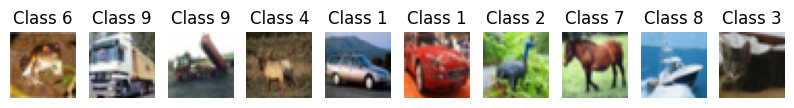


----------cifar10_Train_Start----------


Epoch 1/20
313/313 [==============================] - 16s 41ms/step - loss: 1.3780 - accuracy: 0.5093 - val_loss: 1.9037 - val_accuracy: 0.3769
Epoch 2/20
313/313 [==============================] - 12s 38ms/step - loss: 0.9798 - accuracy: 0.6526 - val_loss: 1.0116 - val_accuracy: 0.6498
Epoch 3/20
313/313 [==============================] - 12s 39ms/step - loss: 0.8081 - accuracy: 0.7163 - val_loss: 0.8543 - val_accuracy: 0.6966
Epoch 4/20
313/313 [==============================] - 12s 38ms/step - loss: 0.7029 - accuracy: 0.7557 - val_loss: 0.8607 - val_accuracy: 0.7106
Epoch 5/20
313/313 [==============================] - 12s 37ms/step - loss: 0.6263 - accuracy: 0.7815 - val_loss: 1.0463 - val_accuracy: 0.6527
Epoch 6/20
313/313 [==============================] - 12s 38ms/step - loss: 0.5540 - accuracy: 0.8082 - val_loss: 0.9897 - val_accuracy: 0.6890
Epoch 7/20
313/313 [==============================] - 12s 37ms/step - loss: 0.5051 - accuracy

In [51]:
m = Machine('cifar10')
m.run()